# 2. Data fetching and processing

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("../../../").resolve()))

%load_ext autoreload
%autoreload 2

## More details about list_models

In [2]:
import pandas as pd
import numpy as np

import pipeGEM as pg
from pipeGEM.data.fetching import list_models, load_remote_model

In [3]:
# search human models

model_list = list_models(organism="human")

In [4]:
model_list

,id,organism,reaction_count,metabolite_count,gene_count,database
1,Human-GEM,Homo sapiens,13024,8363,2920,metabolic atlas
1,iAB_RBC_283,Homo sapiens,469,342,346,BiGG
12,iAT_PLT_636,Homo sapiens,1008,738,636,BiGG
105,RECON1,Homo sapiens,3741,2766,1905,BiGG
106,Recon3D,Homo sapiens,10600,5835,2248,BiGG


In [5]:
# select by number of components

model_list = list_models(organism="mouse", 
                         max_n_genes=2000, max_n_mets=3000, max_n_rxns=5000)

In [6]:
model_list

,id,organism,reaction_count,metabolite_count,gene_count,database
77,iMM1415,Mus musculus,3726,2775,1375,BiGG


## Generate simulated gene data

In [7]:
from pipeGEM.data.synthesis import get_syn_gene_data
import seaborn as sns
import numpy as np

In [8]:
mouse = load_remote_model('iMM1415')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-28


No objective coefficients in model. Unclear what should be optimized


In [9]:
raw_count = get_syn_gene_data(mouse, n_sample=9, random_state=42)
raw_count.head()

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8
12846,14845,162353,11429,67283,155462,1584067,100515,145758,167789
67689,4406663,5444541,2174195,1115432,13400292,766236,913081,1989966,5588672
237940,1524538,3264187,8463146,1826585,3019458,1613887,1405787,7459855,2358988
222,57165,4878,3100,49435,10238,27138,94524,1704,17945
76507,58703,1289389,187994,2591007,579267,972693,1202149,806222,2110348


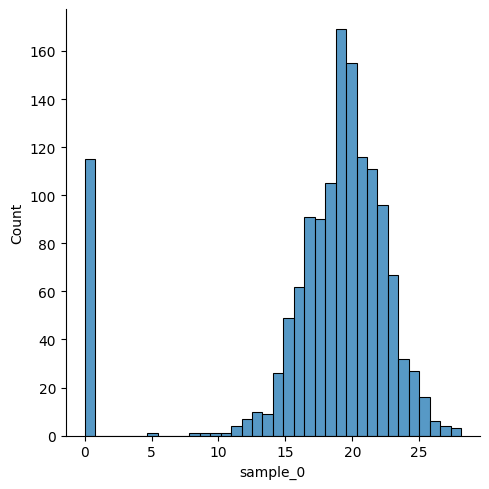

In [10]:
sns.displot(np.log2(raw_count + 1)["sample_0"])

## Maping gene data to a pipeGEM model

In [11]:
from pipeGEM.data import GeneData

In [12]:
p_mouse = pg.Model("imm1415", mouse)

In [13]:
gene_data = GeneData(data=raw_count["sample_0"], 
                     data_transform=lambda x: np.log2(x), 
                     absent_expression=0)

In [14]:
p_mouse.add_gene_data(name_or_prefix="sample_0", 
                      data=gene_data, 
                      or_operation="nanmax",  # alternative: nansum
                      threshold=-np.inf, 
                      absent_value=-np.inf)

100%|███████████████████████████████████████████████████████████████████████████| 3726/3726 [00:00<00:00, 17138.12it/s]

Finished mapping in 0.22806286811828613 seconds.


In [15]:
p_mouse.reactions.get_by_id("2HBt2")

Reaction identifier,2HBt2
Name,2 hydroxybutyrate cotransport with proton
Memory address,0x1e8879ebf10
Stoichiometry,2hb_e + h_e <=> 2hb_c + h_c 2 Hydroxybutyrate C4H7O3 + H+ <=> 2 Hydroxybutyrate C4H7O3 + H+
GPR,80879 or 20503 or 20501
Lower bound,-100000.0
Upper bound,100000.0


In [16]:
p_mouse.gene_data["sample_0"].rxn_scores["2HBt2"]

C:\Users\user\AppData\Local\Temp\ipykernel_20428\3651060646.py:2: RuntimeWarning: divide by zero encountered in log2
  data_transform=lambda x: np.log2(x),


19.428086140626256

In [17]:
gene_data.transformed_gene_data["80879"], gene_data.transformed_gene_data["20503"], gene_data.transformed_gene_data["20501"]

C:\Users\user\AppData\Local\Temp\ipykernel_20428\3651060646.py:2: RuntimeWarning: divide by zero encountered in log2
  data_transform=lambda x: np.log2(x),


(17.02433890053839, 17.910098103986154, 19.428086140626256)

## Finding data thresholds

In [18]:
# modified rFASTCORMICS thresholds
rFASTCORMICS_threshold = gene_data.get_threshold("rFASTCORMICS", return_heuristic=False)

C:\Users\user\AppData\Local\Temp\ipykernel_20428\3651060646.py:2: RuntimeWarning: divide by zero encountered in log2
  data_transform=lambda x: np.log2(x),


transform: True
cutting off 115 data since their expression values are below -inf
data's range: [5.0, 28.13763674747688]
p_score of init values: 0.08537313386787253
original guess:  19.360653430827234 22.139761515007624
best fitted Amps:  0.023454819545848257 0.12048959289201895
best fitted means:  20.62204439000541 19.402609183642905


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\analysis\_threshold.py:158: UserWarning: Fail to find proper parameters, return the best 3 params
  warnings.warn(f"Fail to find proper parameters, return the best {k} params")


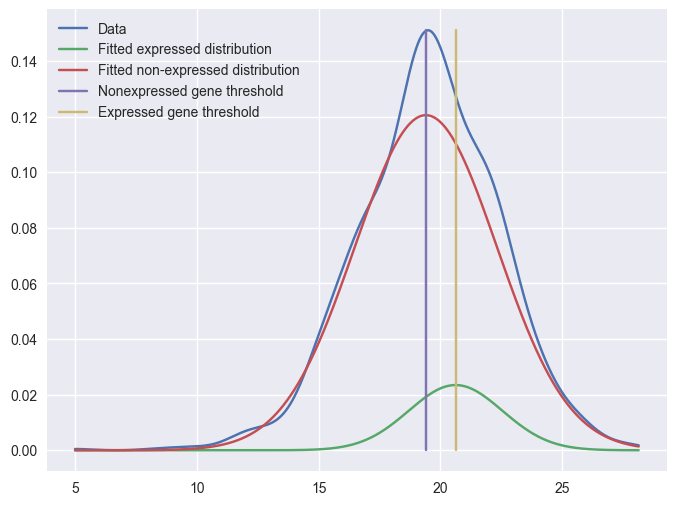

Expression threshold: 20.62204439000541


In [19]:
rFASTCORMICS_threshold.plot()
print(f"Expression threshold: {rFASTCORMICS_threshold.exp_th}")

In [20]:
# percentile thresholds (which are also called 'global threshold')
p_threshold = gene_data.get_threshold("percentile", p=[90, 75, 50])

transform: True


C:\Users\user\AppData\Local\Temp\ipykernel_20428\3651060646.py:2: RuntimeWarning: divide by zero encountered in log2
  data_transform=lambda x: np.log2(x),


In [21]:
p_threshold

PercentileThresholdAnalysis at 0x1e88d1699c0

-----------
Parameters:
{'p': [90, 75, 50], 'exp_p': None, 'non_exp_p': None}
-----------
Result keys:
data, exp_th, non_exp_th, threshold_series

In [22]:
p_threshold.threshold_series

p=90    23.013880
p=75    21.501370
p=50    19.554229
dtype: float64

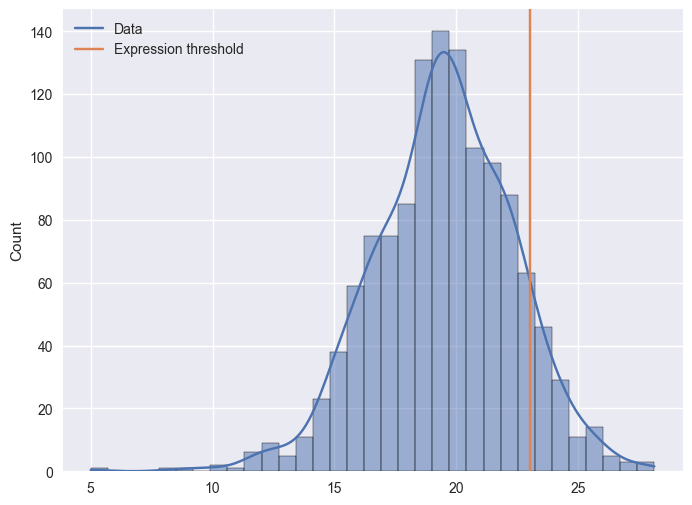

In [23]:
p_threshold.plot()

In [24]:
raw_count

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8
12846,14845,162353,11429,67283,155462,1584067,100515,145758,167789
67689,4406663,5444541,2174195,1115432,13400292,766236,913081,1989966,5588672
237940,1524538,3264187,8463146,1826585,3019458,1613887,1405787,7459855,2358988
222,57165,4878,3100,49435,10238,27138,94524,1704,17945
76507,58703,1289389,187994,2591007,579267,972693,1202149,806222,2110348
...,...,...,...,...,...,...,...,...,...
30955,824385,470969,837334,1383151,2000101,1240493,2203814,216831,85358
18709,330946,2996446,1645833,716716,7043678,13927808,487353,4274073,1665708
20975,1782456,2959058,416373,122911,1537358,1671129,3025042,530628,221207
320634,1302911,179079,1358922,149480,1672668,488008,33415,938677,643217


In [25]:
# To find local threshold, we need to aggregate several GeneData first!
dummy_groups = pd.DataFrame({"gp1": {c: "a" if int(c.split("_")[1]) > 4 else "b" for c in raw_count.columns}})
gene_data_dic = {}

for c in raw_count.columns:

    gene_data_dic[c] = GeneData(data=raw_count[c], 
                                data_transform=lambda x: np.log2(x), 
                                absent_expression=0)
    
agg_gene_data = GeneData.aggregate(gene_data_dic, group_annotation=dummy_groups)
agg_gene_data

DataAggregation at 0x1e88d178610

-----------
Parameters:
{'method': 'concat', 'prop': 'data', 'absent_expression': 0, 'group': {'sample_0': ['sample_0'], 'sample_1': ['sample_1'], 'sample_2': ['sample_2'], 'sample_3': ['sample_3'], 'sample_4': ['sample_4'], 'sample_5': ['sample_5'], 'sample_6': ['sample_6'], 'sample_7': ['sample_7'], 'sample_8': ['sample_8']}}
-----------
Result keys:
agg_data, group_annotation

In [26]:
local_th = agg_gene_data.find_local_threshold(p=50, group_name="gp1")

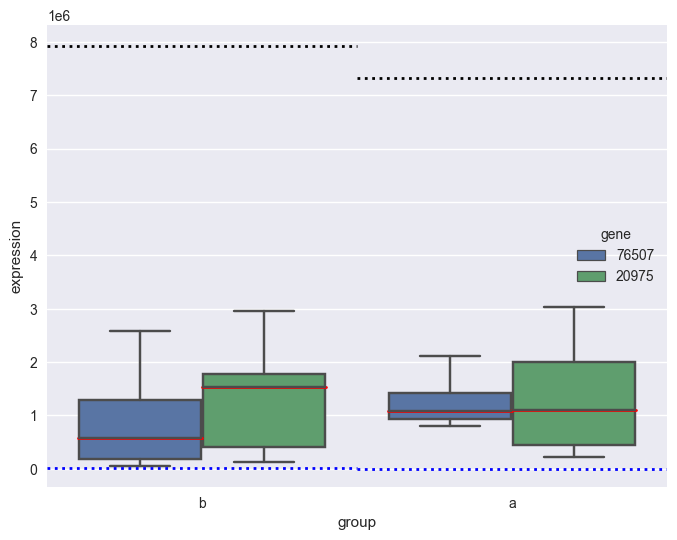

In [27]:
local_th.plot(genes=["76507", "20975"])

## Visualizing gene data

In [28]:
corr_result = agg_gene_data.corr()

In [29]:
corr_result

CorrelationAnalysis at 0x1e88d1d8eb0

-----------
Parameters:
{'by': 'sample'}
-----------
Result keys:
correlation_result

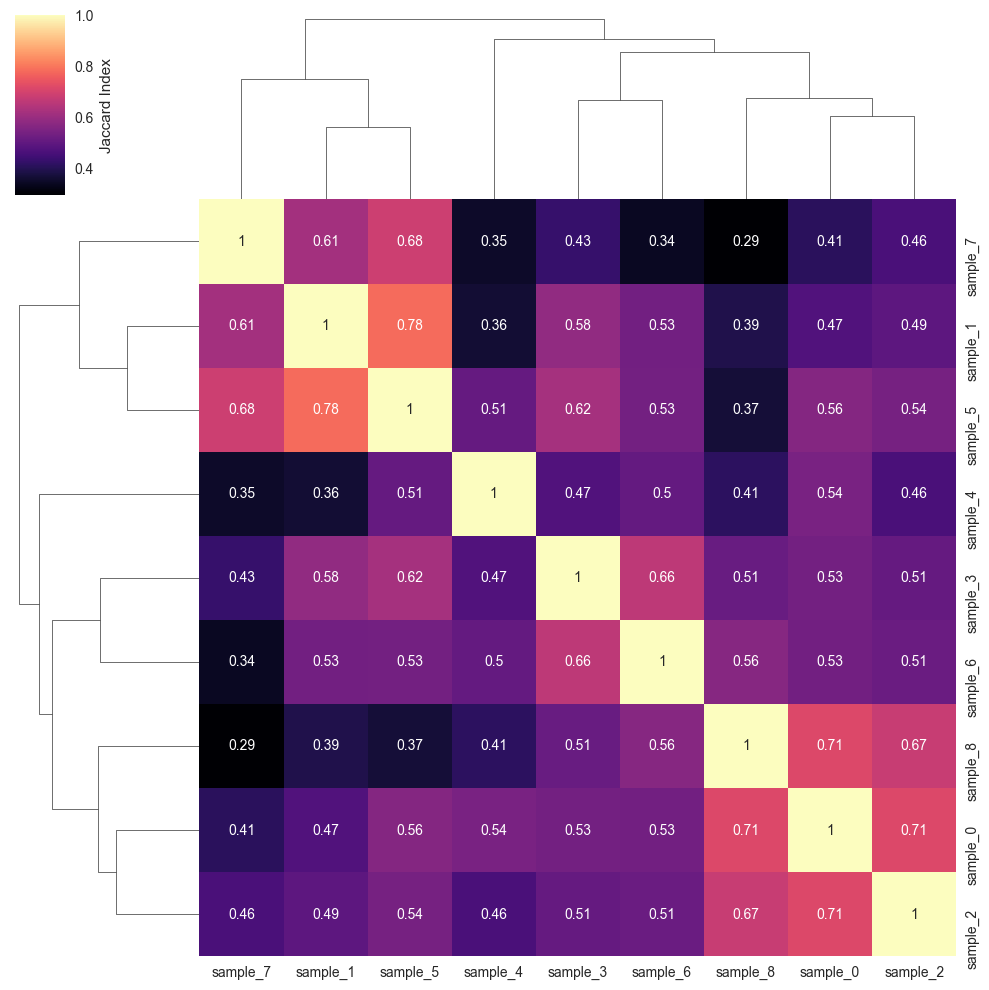

In [30]:
corr_result.plot(annot=True)

In [31]:
pca_result = agg_gene_data.dim_reduction(method="PCA")

In [32]:
pca_result

PCA_Analysis at 0x1e88726f2e0

-----------
Parameters:
{'dr_method': 'PCA', 'method': 'concat', 'prop': 'data', 'absent_expression': 0, 'group': {'sample_0': ['sample_0'], 'sample_1': ['sample_1'], 'sample_2': ['sample_2'], 'sample_3': ['sample_3'], 'sample_4': ['sample_4'], 'sample_5': ['sample_5'], 'sample_6': ['sample_6'], 'sample_7': ['sample_7'], 'sample_8': ['sample_8']}}
-----------
Result keys:
PC, exp_var, components, group_annotation

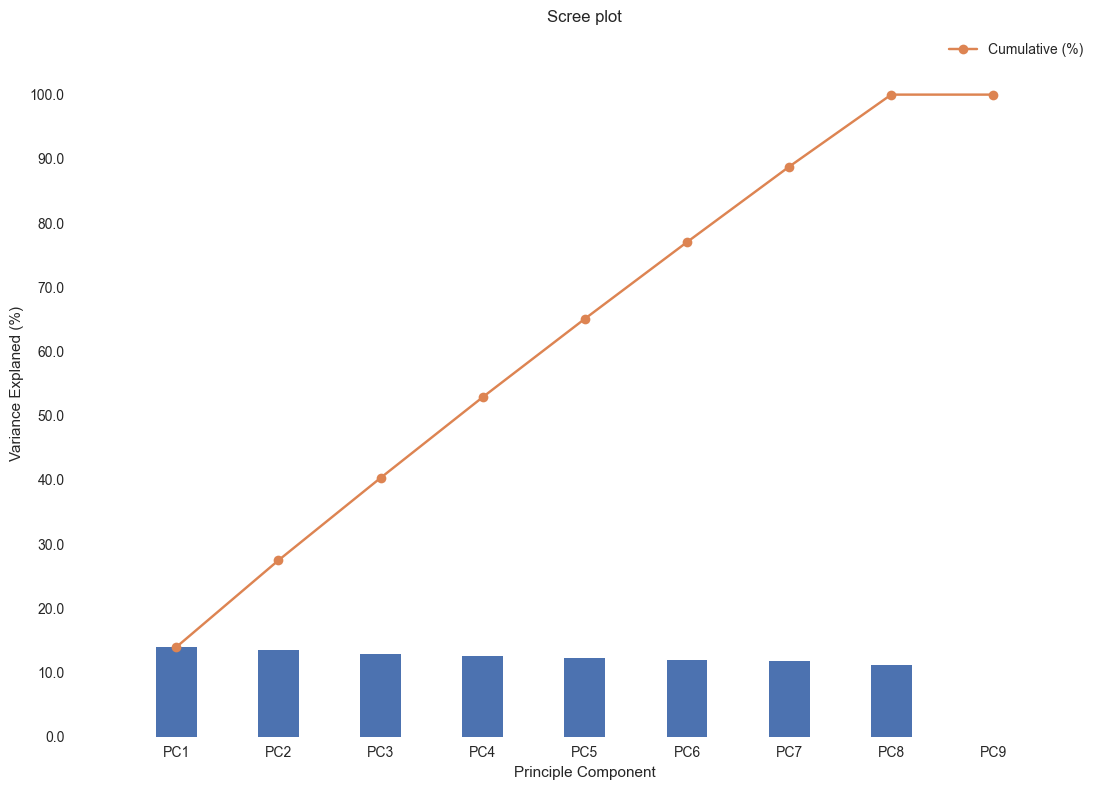

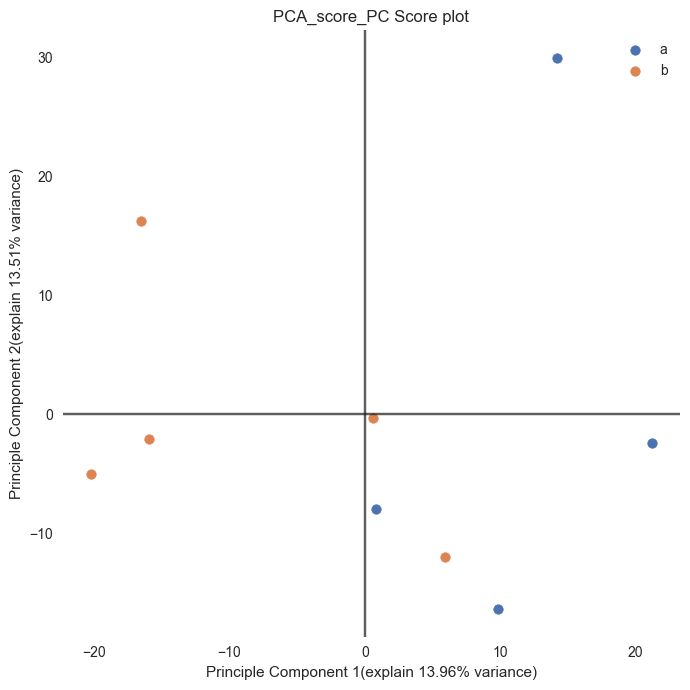

In [33]:
pca_result.plot(color_by="gp1")

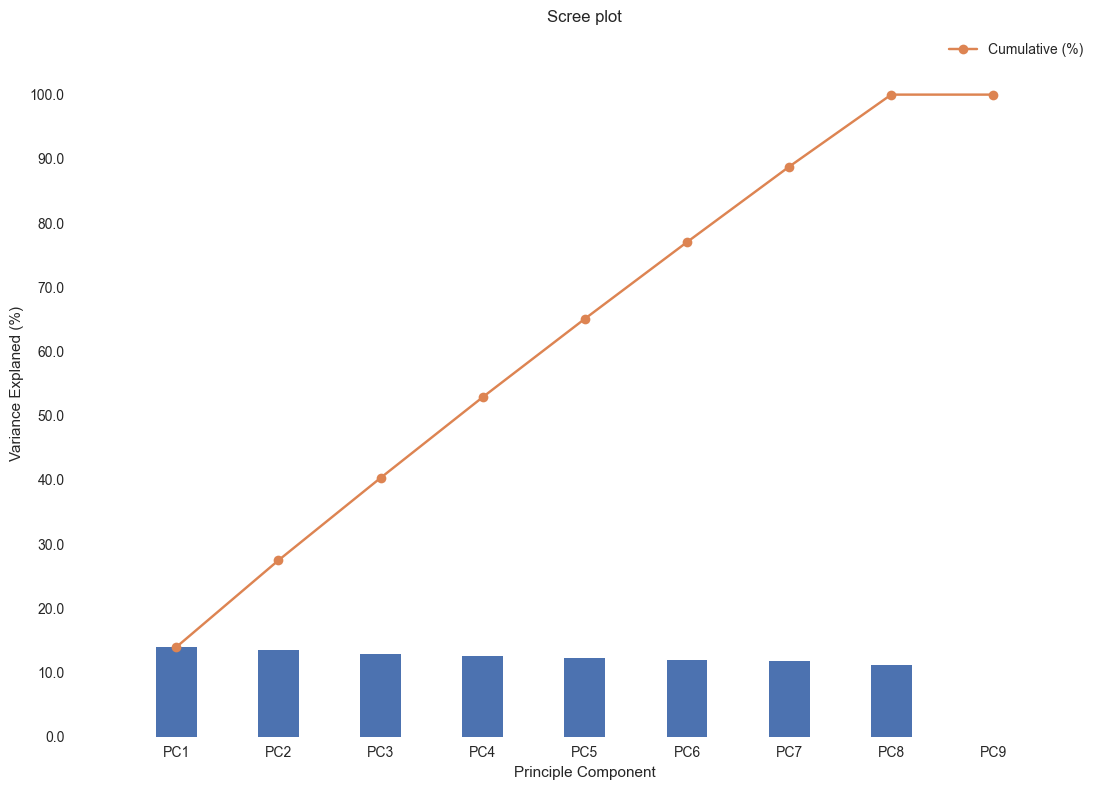

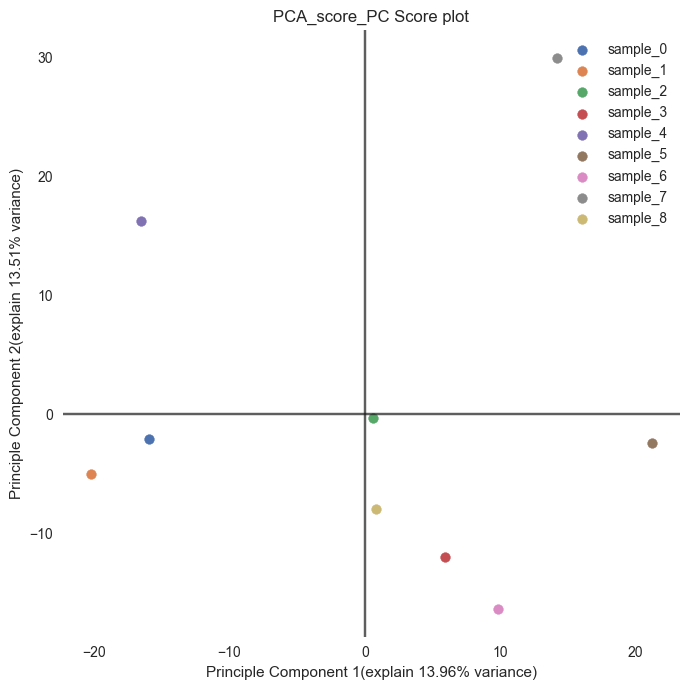

In [36]:
pca_result.plot(color_by="default")

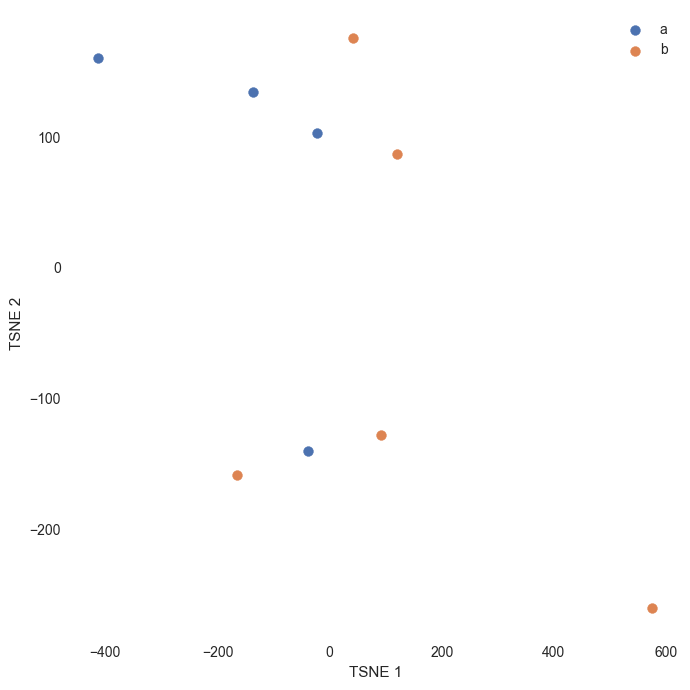

In [37]:
tsne_result = agg_gene_data.dim_reduction(method="TSNE")
tsne_result.plot(color_by="gp1")

C:\Users\user\mambaforge\envs\cobra310\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


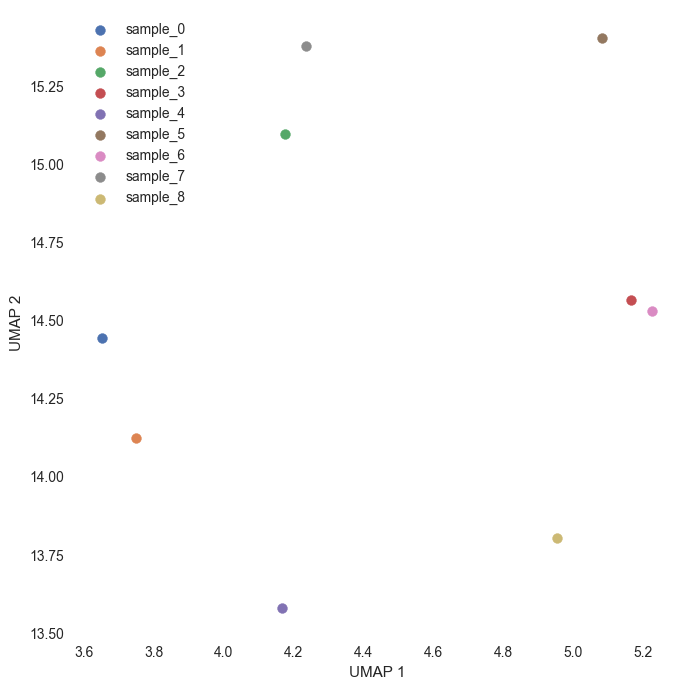

In [39]:
tsne_result = agg_gene_data.dim_reduction(method="UMAP")
tsne_result.plot()

## Medium data

In [40]:
from pipeGEM.data import MediumData

In [43]:
human = load_remote_model("Human-GEM")

Model Human-GEM is already downloaded


In [44]:
human.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
MAM01291e,MAR00566,0.2827,22,0.01%
MAM01771e,MAR00567,0.01104,20,0.00%
MAM01371e,MAR00569,1000,10,10.55%
MAM01741e,MAR00571,0.1629,22,0.00%
MAM01689e,MAR00573,0.5234,22,0.01%
MAM00094e,MAR00575,0.1049,22,0.00%
MAM01696e,MAR00576,3.591,20,0.08%
MAM02648e,MAR00577,0.6377,20,0.01%
MAM01432e,MAR00618,0.01104,26,0.00%
MAM02456e,MAR00620,0.01104,17,0.00%


In [45]:
# load default medium 

dmem_medium = MediumData.from_file("DMEM", id_col_label="human_1")

In [46]:
human = pg.Model(model=human, name_tag="human")

In [47]:
human.add_medium_data(name="dmem", data=dmem_medium)

In [49]:
human.apply_medium(name="dmem")

MAR09047  is an inorganic exchange reaction (not constrained)
MAR09073  is an inorganic exchange reaction (not constrained)
MAR09079  is an inorganic exchange reaction (not constrained)
MAR09088  is an inorganic exchange reaction (not constrained)
MAR09103  is an inorganic exchange reaction (not constrained)
MAR09148  is an inorganic exchange reaction (not constrained)
MAR09149  is an inorganic exchange reaction (not constrained)
MAR09162  is an inorganic exchange reaction (not constrained)
MAR09169  is an inorganic exchange reaction (not constrained)
MAR09204  is an inorganic exchange reaction (not constrained)
MAR09354  is an inorganic exchange reaction (not constrained)
MAR09381  is an inorganic exchange reaction (not constrained)
MAR09383  is an inorganic exchange reaction (not constrained)
MAR09386  is an inorganic exchange reaction (not constrained)
MAR09432  is an inorganic exchange reaction (not constrained)
MAR09703  is an inorganic exchange reaction (not constrained)
MAR04154

In [51]:
human.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
MAM02685e,MAR00656,1000,7,15.82%
MAM01965e,MAR09034,689.7,6,9.35%
MAM02125e,MAR09038,374.2,6,5.07%
MAM02184e,MAR09039,17.46,6,0.24%
MAM02360e,MAR09040,35.61,6,0.48%
MAM02426e,MAR09041,27.92,6,0.38%
MAM02471e,MAR09042,8.719,5,0.10%
MAM02724e,MAR09043,14.77,9,0.30%
MAM02993e,MAR09044,22.06,4,0.20%
MAM03089e,MAR09045,3.827,11,0.10%
